In [1]:
from src import *

In [2]:
def interpolate_connectivity(fmri_bundles, bundles_ij, rcomb, regions_correlation, dim, normalizing=True, wmmask=None):
    """
    Compute interpolated connectivity on white matter bundles
    """
    # Iterate across all the bundles and populate each voxels by the timcourses
    wm_inpainted = np.zeros(dim)
    wm_inpainted_masked = None
    normalizing_matrix = np.zeros(dim) # Count number of times a voxel belonged to a bundle to average out
    for k in tqdm(range(len(bundles_ij))):
        i,j = bundles_ij[k]

        volcoords_interest = fmri_bundles[k]
        avg_betweenbundle_conn = regions_correlation[i-1,j-1]

        for coord in volcoords_interest:
            x,y,z = coord
            wm_inpainted[x,y,z] = wm_inpainted[x,y,z] + rcomb[k] *  avg_betweenbundle_conn
            normalizing_matrix[x,y,z] = normalizing_matrix[x,y,z] + np.abs(rcomb[k])

    normalizing_matrix[normalizing_matrix == 0] = np.inf
    if normalizing:
        wm_inpainted = wm_inpainted/np.abs(normalizing_matrix)    

    # Out of bound encoding for backgrounds
    wm_inpainted[wm_inpainted == 0] = -10

    if not wmmask is None:
        # Apply a white matter mask if we care only about correct bundle masking
        wm_inpainted_masked = wm_inpainted * wmmask
        wm_inpainted_masked[wm_inpainted_masked == 0] = -10
    
    return wm_inpainted, wm_inpainted_masked

def plot_compare_inpainting(list_inpaintings, coords_of_interest, affines, inpaint_names, vmin=-1, vmax=1, draw_cross=False):
    """
    Compare the inpaintings by plotting various of them at different slice of interest
    """
    r = len(list_inpaintings)
    nbc = 3
    if r % nbc == 0:
        nbr = r//nbc
    else:
        nbr = r//nbc + 1
    fig, ax = plt.subplots(nbr,nbc, figsize=(8*nbc,5*nbr), facecolor='black')
    cmap = mpl.colormaps.get_cmap('jet')
    cmap.set_extremes(under='black', over='black')
    
    for r in range(nbr):
        for c in range(nbc):
            idx = r * nbc + c
            if nbr == 1: 
                plot_epi(nib.Nifti1Image(list_inpaintings[idx], affine=affines[idx]),colorbar=True, 
                         cut_coords=coords_of_interest[idx], axes=ax[c], cmap=cmap, vmin=vmin, vmax=vmax, draw_cross=draw_cross)
                ax[c].set_title(inpaint_names[idx], color='white')
            else:
                plot_epi(nib.Nifti1Image(list_inpaintings[idx], affine=affines[idx]),colorbar=True, 
                         cut_coords=coords_of_interest[idx], axes=ax[r,c], cmap=cmap, vmin=vmin, vmax=vmax, draw_cross=draw_cross)
                ax[r,c].set_title(inpaint_names[idx], color='white')

    plt.suptitle(f'Bundle {int(np.ceil(thresh_subjapp))}', color='white')

## Goal

The goal of this notebook is to do inpainting. Allowing for negative weightings of bundle to generate bundles, and allowing as well negatively connected bundles to exist

## Description



- Scale1 -> ~95
- Scale2 -> ~140
- Scale3 -> ~240

Structuring of folder h5: 
- ['atlas', 'header', 'matrices']:
    - atlas:
        - bundles 10-59
        - bundles 11-23
        - ...
    - header: 
        - affine, dim, gmcodes, gmcolors, gmcoords, gmregions, nsubjects, voxsize
    - matrices:
        - consistency
        - length
        - numbStlines

In [3]:
connFilename = '../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale1.h5'
hf = h5py.File(connFilename, 'r')

In [4]:
centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
dim = hf.get('header').get('dim')[()]
fiber_affine = hf.get('header').get('affine')[()]

gmregions_names = hf.get('header').get('gmregions')[()]
# use the masks if necessary when we select too much bundles for reconstruction
gm_mask_subj = nib.load('../atlas_data/rstfMRI_eg/gm_mask_subj7.nii').get_fdata()
wm_mask_subj = (gm_mask_subj + 1) % 2

In [11]:
region_of_interest = ['ctx-rh-posteriorcingulate', 'ctx-lh-posteriorcingulate']
index_of_interest = [np.where(gmregions_names.astype(str) == r)[0][0] 
                     for r in region_of_interest]

index_of_interest = np.array(index_of_interest)
gmregions_names[index_of_interest]

array([b'ctx-rh-posteriorcingulate', b'ctx-lh-posteriorcingulate'],
      dtype='|S49')

### Statistic Views

In [20]:
consistency_view = get_aggprop(hf, 'consistency')
length_view = get_aggprop(hf, 'length')
nbStlines_view = get_aggprop(hf, 'numbStlines')
nb_regions = consistency_view.shape[0]

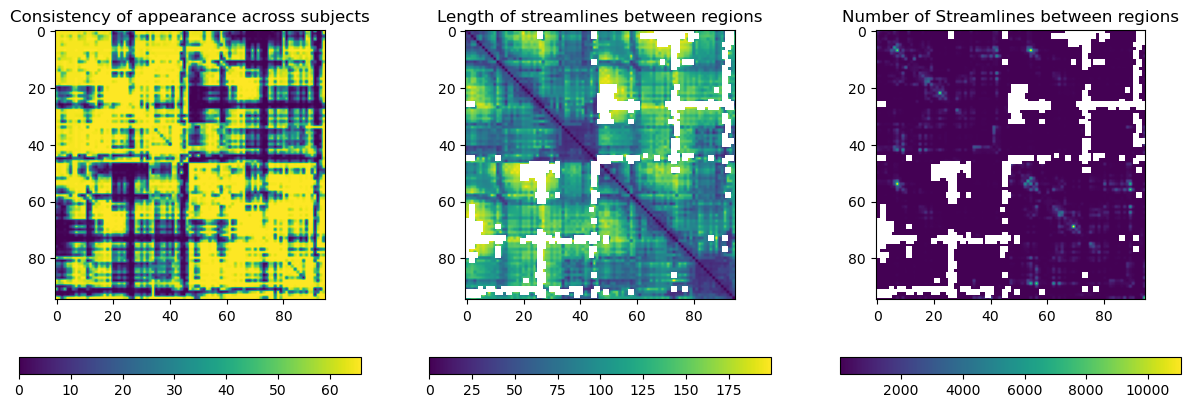

In [21]:
# Ploting the stats view
fig, ax = plt.subplots(1,3, figsize=(15,5))
im0 = ax[0].imshow(consistency_view)
im1 = ax[1].imshow(length_view)
im2 = ax[2].imshow(nbStlines_view)
ax[0].set_title('Consistency of appearance across subjects')
ax[1].set_title('Length of streamlines between regions')
ax[2].set_title('Number of Streamlines between regions')
fig.colorbar(im0,  orientation='horizontal')
fig.colorbar(im1,  orientation='horizontal')
fig.colorbar(im2,  orientation='horizontal')

### Bundles specifics

In [22]:
streamline = get_bundles_betweenreg(hf, 3,78)

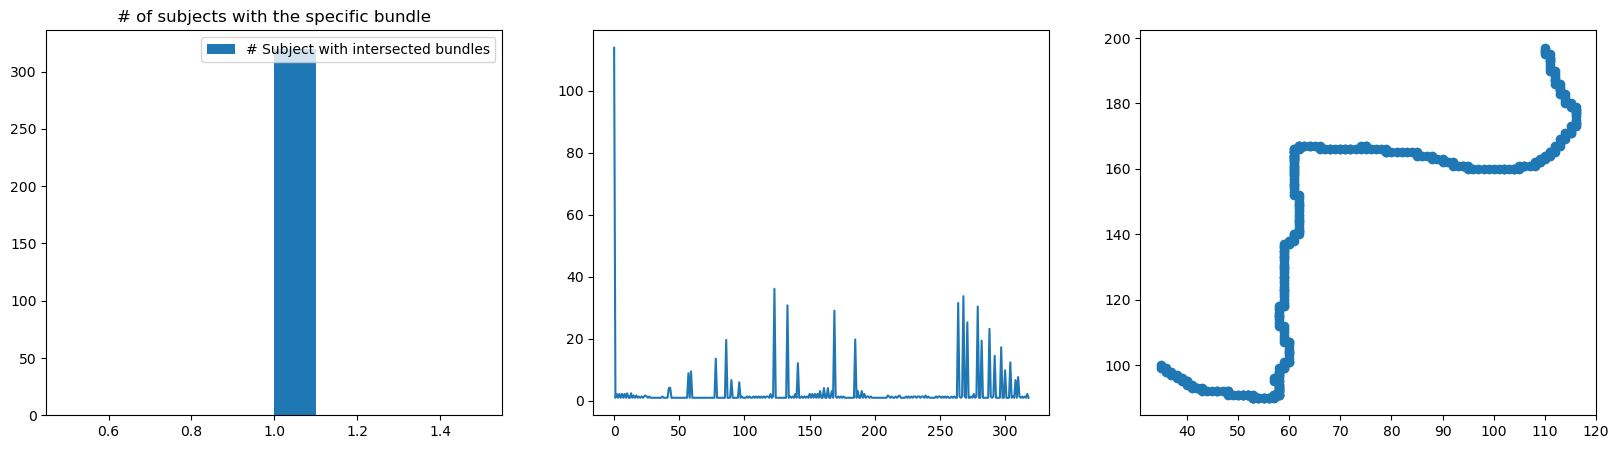

In [23]:
path_motion = []
coords = streamline[:,[0,1,2]]
for k in range(streamline.shape[0]-1):
    dist = np.sqrt(np.sum((coords[k] - coords[k-1]) ** 2))
    path_motion.append(dist)

fig ,ax = plt.subplots(1,3, figsize=(20,5))
ax[0].hist(streamline[:,3], label='# Subject with intersected bundles')
ax[0].set_title('# of subjects with the specific bundle')
ax[0].legend()
ax[1].plot(path_motion)
ax[2].scatter(coords[:,0],coords[:,1])
# plt.xlim(0,100)

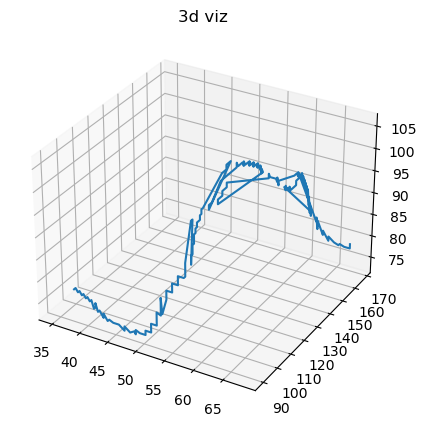

In [24]:
fig,axs = plt.subplots(1,1,subplot_kw=dict(projection='3d'),figsize=(5,5))

length_order = 200
x=coords[:,0][:length_order]
y=coords[:,1][:length_order]
z=coords[:,2][:length_order]

axs.plot(x,y,z)
axs.set_title('3d viz')
plt.show()

### Compute seed connectivity

In [31]:
from nilearn.regions import connected_label_regions
atlas_schaefer = datasets.fetch_atlas_schaefer_2018(yeo_networks=17)
region_labels = connected_label_regions(atlas_schaefer['maps'])
resampled = nimg.resample_to_img(region_labels, rst_vol, interpolation = 'nearest')

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/nilearn/regions/region_extractor.py:608: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  new_labels_img = new_img_like(labels_img, new_labels_data, affine=affine)


In [ ]:
index_of_interestschaef = np.array([idx+1 for idx, f in enumerate(atlas_schaefer['labels']) if 'PCC' in str(f)])

In [48]:
# tmp = ftimecourse[np.isin(resampled_lausanne.get_fdata(), index_of_interest + 1)]
# movie_mean = np.mean([gaussian_filter1d(tmp[k],1.2) for k in range(len(tmp))],axis=0)

tmp = ftimecourse[np.isin(resampled.get_fdata(), index_of_interestschaef)]
movie_mean = np.mean([gaussian_filter1d(tmp[k],1.2) for k in range(len(tmp))],axis=0)

In [51]:
# seed functional connectivity on PCC
seedfunc_vol = np.zeros((ftimecourse.shape[:-1]))
for x in tqdm(range(seedfunc_vol.shape[0])):
    for y in range(seedfunc_vol.shape[1]):
        for z in range(seedfunc_vol.shape[2]):
            seedfunc_vol[x,y,z] = pearsonr(movie_mean, ftimecourse[x,y,z])[0]

  0%|          | 0/91 [00:00<?, ?it/s]/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 91/91 [01:43<00:00,  1.14s/it]


/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


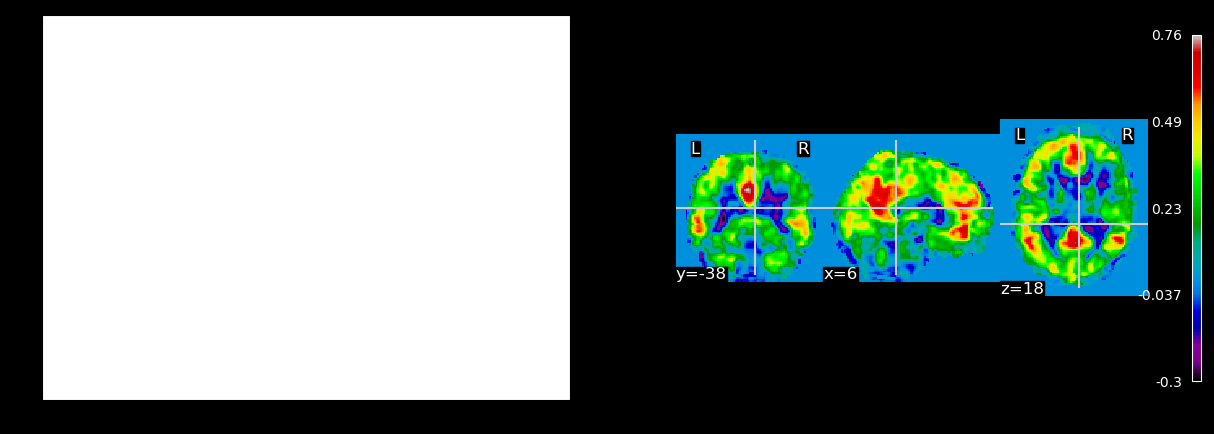

In [65]:
fig,ax = plt.subplots(1,2, figsize=(15,5), facecolor='black')
# @ PCC
# plot_epi(abs_nifti(mean_fmri(rst_vol)), colorbar=True, cut_coords=(6,-38,18), axes=ax[0])
# Visualizing the functional connectivity strength by seed connectivity (seed -> PCC)
plot_epi(nib.Nifti1Image(seedfunc_vol, affine=rest_affine), colorbar=True, cut_coords=(6,-38,18), axes=ax[1])
# plot_epi(nib.Nifti1Image(seedfunc_vol, affine=rest_affine), colorbar=True, axes=ax[1])

In [ ]:
# 1. Transform the voxels to coordinates
# 2. Match the coordinates i.e the voxels to a given label
# 3. Obtain an mapping of a voxel to the parcels

target_vol = rst_hcp
labels_vol = np.zeros(target_vol.shape[:3])
for x in tqdm(range(target_vol.shape[0])):
    for y in range(target_vol.shape[1]):
        for z in range(target_vol.shape[2]):
            # Find the MNI coordinates of the voxel (x, y, z)
            spatial_coord = np.array(image.coord_transform(x, y, z, target_vol.affine))
            labels_vol[x,y,z] = np.argmin(np.sum((centers - spatial_coord) ** 2, axis=1))

# Atlas averaging timecourses
avg_tc = np.zeros((centers.shape[0], target_vol.shape[-1]))
for t in tqdm(range(target_vol.shape[-1])):
    tmp = target_vol.get_fdata()[:,:,:,t]
    for k in range(centers.shape[0]):
        indexes = (labels_vol == k)
        nonzero = tmp[indexes][(tmp[indexes] != 0)]
        avg_tc[k,t] = nonzero.mean()

  0%|          | 0/91 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [01:49<00:00, 10.99it/s]


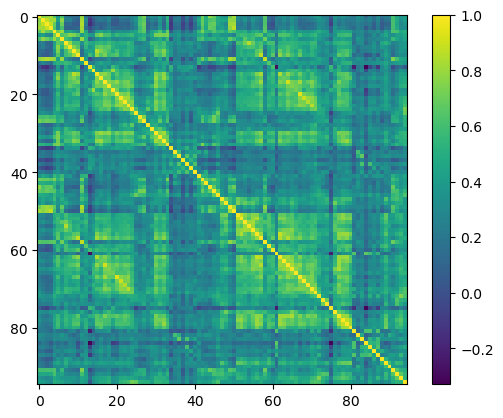

In [ ]:
corr_mat = np.zeros((avg_tc.shape[0],avg_tc.shape[0]))
for k in range(avg_tc.shape[0]):
    corr_mat[k] = nta.SeedCorrelationAnalyzer(avg_tc[k], avg_tc).corrcoef

plt.imshow(corr_mat)
plt.colorbar()

### Computing regularized regression on fibers combination for seed functional connectivity explanation

Bundle property-based regularizer:
- We define the following metric 1 $$||(\frac{{\bf x}}{{\bf C}})||_2^2 $$
- We define the following metric 2 $$||(\frac{{\bf x}}{{\bf C}})||_1 $$
- We define the following metric 3 $$||({\bf x}^\frac{1}{{\bf C}})||_2 $$

Properties of bundles include the consistency, length and number of streamlines composing the bundle

#### 1. End-region encoded vectors

In [ ]:
thresh_subjapp = int(np.ceil(nsubject * 0.3)) # consider bundles that appaear at least in 30 % of the subjects

In [ ]:
# Generating the X samples and the y samples
# 1. Careful as well to remove the auto-correlation in the diagonal
# 2. Raster scan parsing meaning that it is the activity of (R0,R1) -> (R0,R2) -> (R0,R3) etc...
# Define matrix of end points on cortex
X = []
bundles_labels = []
pairs = np.zeros((nb_regions, nb_regions))
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))
        pairs[i-1,j-1] = 1.0
        vec = np.zeros(nb_regions)
        vec[i-1] = 1.0
        vec[j-1] = 1.0
        X.append(vec)

X = np.asarray(X)

100%|██████████| 95/95 [00:30<00:00,  3.10it/s]


In [ ]:
# Compute a regularizer taking into account the probability of a voxel belonging to the fibers
# Here is the loss we consider
sparsing_distrib = 2
# Consistency-based scaling
Cscale1 = (np.array([consistency_view[p[0]-1,p[1]-1]/nsubject for p in bundles_labels])) ** sparsing_distrib

# Length of bundle based scaling
Lscale1 = np.array([length_view[p[0]-1,p[1]-1] for p in bundles_labels])
Lscale1 /= Lscale1.max()

# Nb of streamlines of bundle based scaling
Sscale1 = np.array([nbStlines_view[p[0]-1,p[1]-1] for p in bundles_labels])
Sscale1 /= Sscale1.max()

In [ ]:
# #Using mean connectivity of all regions
# y = (corr_mat - np.eye((nb_regions))).mean(axis=0)

# #Using connectivity again PCC
y = corr_mat[index_of_interest].mean(axis=0)

In [ ]:
# Ridge
regularizers = np.sort(np.concatenate([np.logspace(0,5,6), np.logspace(0,5,6) / 2]))
coefs = []
scores = []
intercepts = []
for k in tqdm(range(len(regularizers))):
    clf = Ridge(alpha=regularizers[k])
    clf.fit(X.T, y)
    scores.append(((clf.predict(X.T) - y) ** 2).mean())
    coefs.append(clf.coef_)
    intercepts.append(clf.intercept_)

# Lasso
regularizers_lasso = np.sort(np.concatenate([np.logspace(-5,0,6), np.logspace(-5,0,6) / 2]))
coefs_lasso = []
scores_lasso = []
intercepts_lasso = []
for k in tqdm(range(len(regularizers_lasso))):
    clf = Lasso(alpha=regularizers_lasso[k])
    clf.fit(X.T, y)
    scores_lasso.append(((clf.predict(X.T) - y) ** 2).mean())
    coefs_lasso.append(clf.coef_)
    intercepts_lasso.append(clf.intercept_)

  0%|          | 0/12 [00:00<?, ?it/s]/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e-03, tolerance: 3.529e-04
  model = cd_fast.enet_coordinate_descent(
100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Bundle probability regularizer accounted linear regression

In [ ]:
nbepoch = 10000
cL2_reg = optimize_lreg(X, y, Cscale1, 'L2', verbose=True, num_epochs=nbepoch)
cL1_reg = optimize_lreg(X, y, Cscale1, 'L1', verbose=True, num_epochs=nbepoch)
cPL2_reg = optimize_lreg(X, y, Cscale1, 'PL2', verbose=True, num_epochs=nbepoch)

lL2_reg = optimize_lreg(X, y, Lscale1, 'L2', verbose=True, num_epochs=nbepoch)
lL1_reg = optimize_lreg(X, y, Lscale1, 'L1', verbose=True, num_epochs=nbepoch)
lPL2_reg = optimize_lreg(X, y, Lscale1, 'PL2', verbose=True, num_epochs=nbepoch)

sL2_reg = optimize_lreg(X, y, Sscale1, 'L2', verbose=True, num_epochs=nbepoch)
sL1_reg = optimize_lreg(X, y, Sscale1, 'L1', verbose=True, num_epochs=nbepoch)
sPL2_reg = optimize_lreg(X, y, Sscale1, 'PL2', verbose=True, num_epochs=nbepoch)

100%|██████████| 10000/10000 [00:04<00:00, 2108.12it/s]


Losses are decomposed into generic loss=3.1076637242222205e-05 and regularizer loss=9.077088179765269e-05


100%|██████████| 10000/10000 [00:04<00:00, 2128.30it/s]


Losses are decomposed into generic loss=0.01589939370751381 and regularizer loss=0.0015427537728101015


100%|██████████| 10000/10000 [00:04<00:00, 2092.17it/s]


Losses are decomposed into generic loss=0.013421609066426754 and regularizer loss=0.0015685561811551452


100%|██████████| 10000/10000 [00:04<00:00, 2209.34it/s]


Losses are decomposed into generic loss=0.0009579495526850224 and regularizer loss=0.00036678111064247787


100%|██████████| 10000/10000 [00:04<00:00, 2224.10it/s]


Losses are decomposed into generic loss=0.033438071608543396 and regularizer loss=0.0006467670318670571


100%|██████████| 10000/10000 [00:04<00:00, 2056.56it/s]


Losses are decomposed into generic loss=5.475729949466768e-07 and regularizer loss=2.2808831090515014e-06


100%|██████████| 10000/10000 [00:04<00:00, 2255.61it/s]


Losses are decomposed into generic loss=0.02898743562400341 and regularizer loss=0.00034343235893175006


100%|██████████| 10000/10000 [00:04<00:00, 2283.17it/s]


Losses are decomposed into generic loss=0.03690003231167793 and regularizer loss=0.016087837517261505


100%|██████████| 10000/10000 [00:05<00:00, 1962.99it/s]

Losses are decomposed into generic loss=2.873447435547405e-08 and regularizer loss=6.56003464882815e-08


In [ ]:
# Saving the weights regressed depending on the bundles used and y values used
trained_weights = {'coefs_ridge': coefs, 'coefs_lasso': coefs_lasso, 
                    'cl2_reg': cL2_reg, 'cl1_reg': cL1_reg, 'cpl2_reg': cPL2_reg,
                    'lL2_reg': lL2_reg, 'lL1_reg': lL1_reg, 'lPL2_reg': lPL2_reg,
                    'sL2_reg': sL2_reg, 'sL1_reg':sL1_reg, 'sPL2_reg': sPL2_reg}
save('./resources/weights_regressors/seedPCC_HCP_bundlediv{}.pkl'.format(thresh_subjapp),array=trained_weights)

### Reconstruction of the fMRI timecourses in WM bundles / voxels levels

- Bring back the GM voxel level timecourses
- Assign timecourse value on voxel being the weighted value of a voxel (so can regenerate WM volumes first then average)
- Recompute the seed connectivity of a given region versus all and show it on the volume (voxel levels)

In [ ]:
trained_weights = load(f'./resources/weights_regressors/seedPCC_HCP_bundlediv{thresh_subjapp}.pkl')

coefs = trained_weights['coefs_ridge']
coefs_lasso = trained_weights['coefs_lasso']
cL2_reg = trained_weights['cl2_reg']
cL1_reg = trained_weights['cl1_reg']
cPL2_reg = trained_weights['cpl2_reg']
lL2_reg = trained_weights['lL2_reg']
lL1_reg = trained_weights['lL1_reg']
lPL2_reg = trained_weights['lPL2_reg']
sL2_reg = trained_weights['sL2_reg']
sL1_reg = trained_weights['sL1_reg']
sPL2_reg = trained_weights['sPL2_reg']

In [ ]:
bundle_affine = np.array(hf.get('header').get('affine'))[()]

Making Access easier - transforming bundles to fmri coordinates / fmri volumes masks

In [ ]:
trans_affine = np.matmul(np.linalg.inv(rest_affine), bundle_affine)

fmri_coords = []
for k in tqdm(range(len(bundles_labels))):
    i,j = bundles_labels[k]
    streamline = get_bundles_betweenreg(hf, i,j)
    streamline = streamline[streamline[:,3] >= thresh_subjapp]

    # Transform voxel indexes of a volume to voxel index of another volume
    volcoords_interest = volcoord2mnicoord(streamline[:,[0,1,2]], trans_affine).astype(int)
    fmri_coords.append(volcoords_interest)

# Save the space coords matching
save('./resources/scale1_fmri2atlas_coords_div{}.pkl'.format(int(np.ceil(thresh_subjapp))), fmri_coords)

100%|██████████| 864/864 [00:09<00:00, 92.04it/s] 


In [ ]:
fmri_coords = load('./resources/scale1_fmri2atlas_coords_div{}.pkl'.format(int(np.ceil(thresh_subjapp))))

Interpolate the connectivity of WM bundles at voxel levels

In [ ]:
vdim = smoothened.shape[:3]

In [ ]:
wm_inpainted_lasso, wm_inpainted_lassoM = interpolate_connectivity(fmri_coords, bundles_labels, coefs_lasso[4], corr_mat, vdim, wmmask=wm_mask_subj, normalizing=False)
wm_inpainted_ridge, wm_inpainted_ridgeM = interpolate_connectivity(fmri_coords, bundles_labels, coefs[3], corr_mat, vdim, wmmask=wm_mask_subj, normalizing=False)
wm_inpainted_lreg, wm_inpainted_lregM = interpolate_connectivity(fmri_coords, bundles_labels, cL2_reg, corr_mat, vdim, wmmask=wm_mask_subj, normalizing=False)

wm_inpainted_lreg1, wm_inpainted_lreg1M = interpolate_connectivity(fmri_coords, bundles_labels, cL1_reg, corr_mat, vdim, wmmask=wm_mask_subj, normalizing=False)
wm_inpainted_lregP, wm_inpainted_lregPM = interpolate_connectivity(fmri_coords, bundles_labels, cPL2_reg, corr_mat, vdim, wmmask=wm_mask_subj, normalizing=False)

wm_inpainted_slreg, wm_inpainted_slregM = interpolate_connectivity(fmri_coords, bundles_labels, sL2_reg, corr_mat, vdim, wmmask=wm_mask_subj, normalizing=False)
wm_inpainted_slreg1, wm_inpainted_slreg1M = interpolate_connectivity(fmri_coords, bundles_labels, sL1_reg, corr_mat, vdim, wmmask=wm_mask_subj, normalizing=False)
wm_inpainted_slregP, wm_inpainted_slregPM = interpolate_connectivity(fmri_coords, bundles_labels, sPL2_reg, corr_mat, vdim, wmmask=wm_mask_subj, normalizing=False)

wm_inpainted_llreg, wm_inpainted_llregM = interpolate_connectivity(fmri_coords, bundles_labels, lL2_reg, corr_mat, vdim, wmmask=wm_mask_subj, normalizing=False)
wm_inpainted_llreg1, wm_inpainted_llreg1M = interpolate_connectivity(fmri_coords, bundles_labels, lL1_reg, corr_mat, vdim, wmmask=wm_mask_subj, normalizing=False)
wm_inpainted_llregP, wm_inpainted_llregPM = interpolate_connectivity(fmri_coords, bundles_labels, lPL2_reg, corr_mat, vdim, wmmask=wm_mask_subj, normalizing=False)

100%|██████████| 1449/1449 [00:14<00:00, 99.54it/s] 


Comparing inpainting models (display only wm bundles of interest)

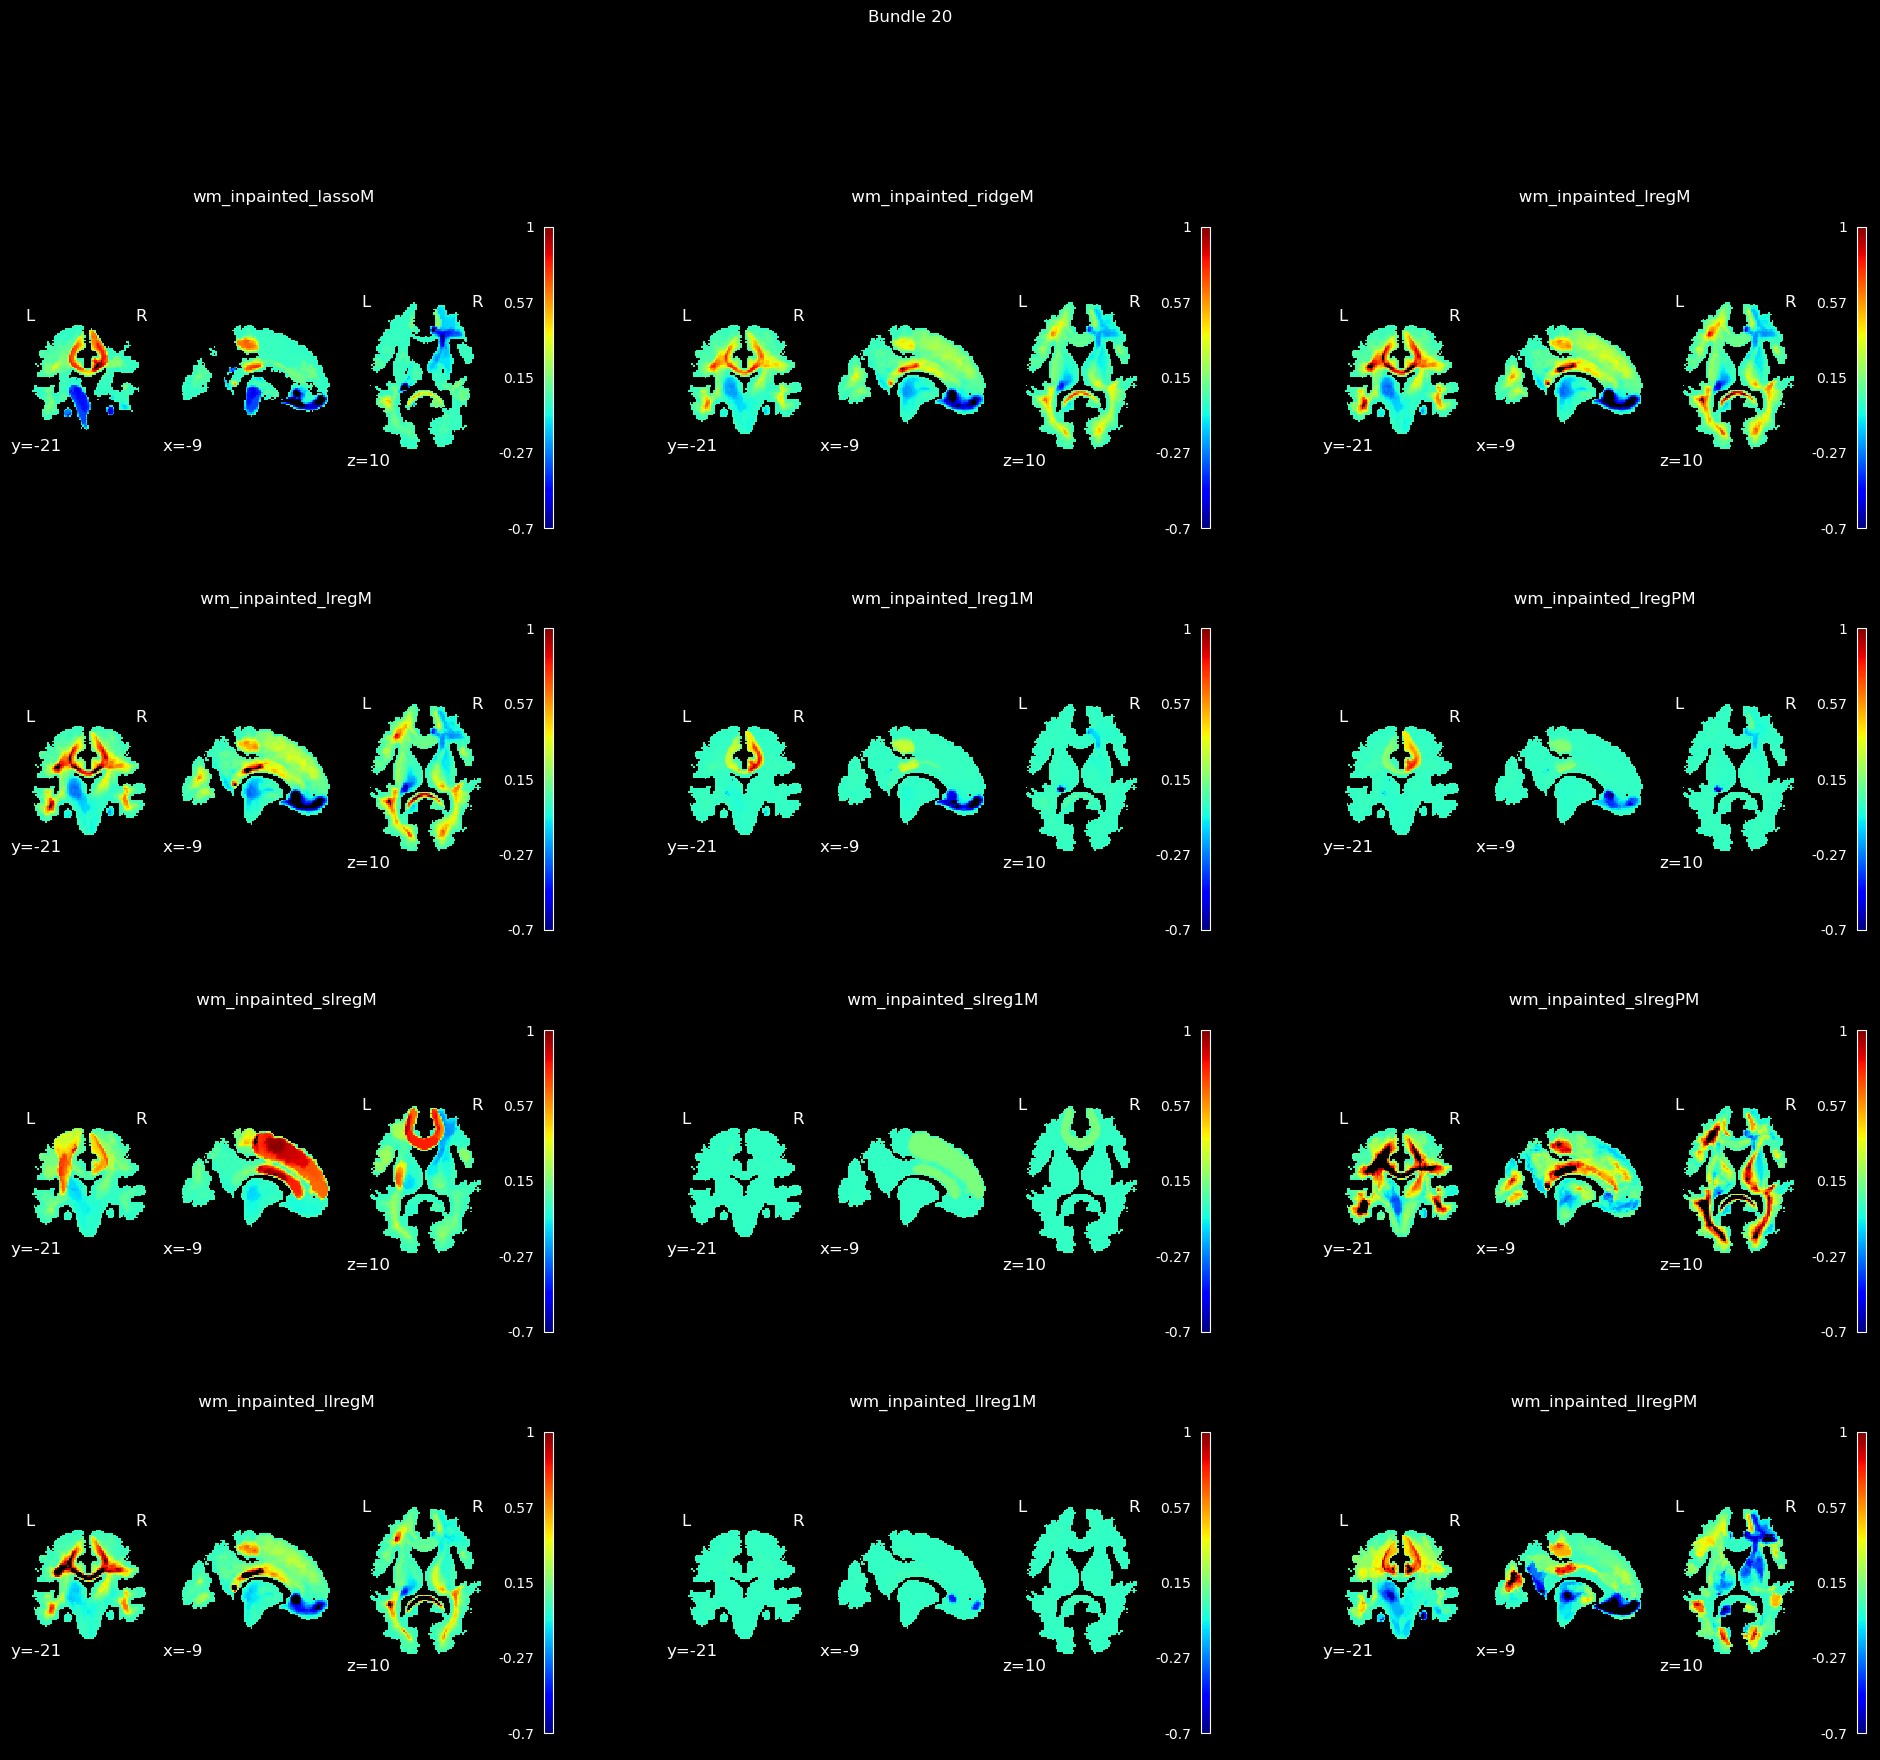

In [ ]:
inpaint_mods = [wm_inpainted_lasso, wm_inpainted_ridge,   wm_inpainted_lreg,
            wm_inpainted_lreg, wm_inpainted_lreg1,   wm_inpainted_lregP,
            wm_inpainted_slreg, wm_inpainted_slreg1,   wm_inpainted_slregP,
            wm_inpainted_llreg, wm_inpainted_llreg1,   wm_inpainted_llregP]

all_inpaints_names = 'wm_inpainted_lassoM, wm_inpainted_ridgeM,   wm_inpainted_lregM, wm_inpainted_lregM, wm_inpainted_lreg1M,   wm_inpainted_lregPM, wm_inpainted_slregM, wm_inpainted_slreg1M,   wm_inpainted_slregPM, wm_inpainted_llregM, wm_inpainted_llreg1M,   wm_inpainted_llregPM'.split(',')

affines = [affine] * 12
coords_of_interest = [(-9,-21,10)] * 12
plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-0.7)

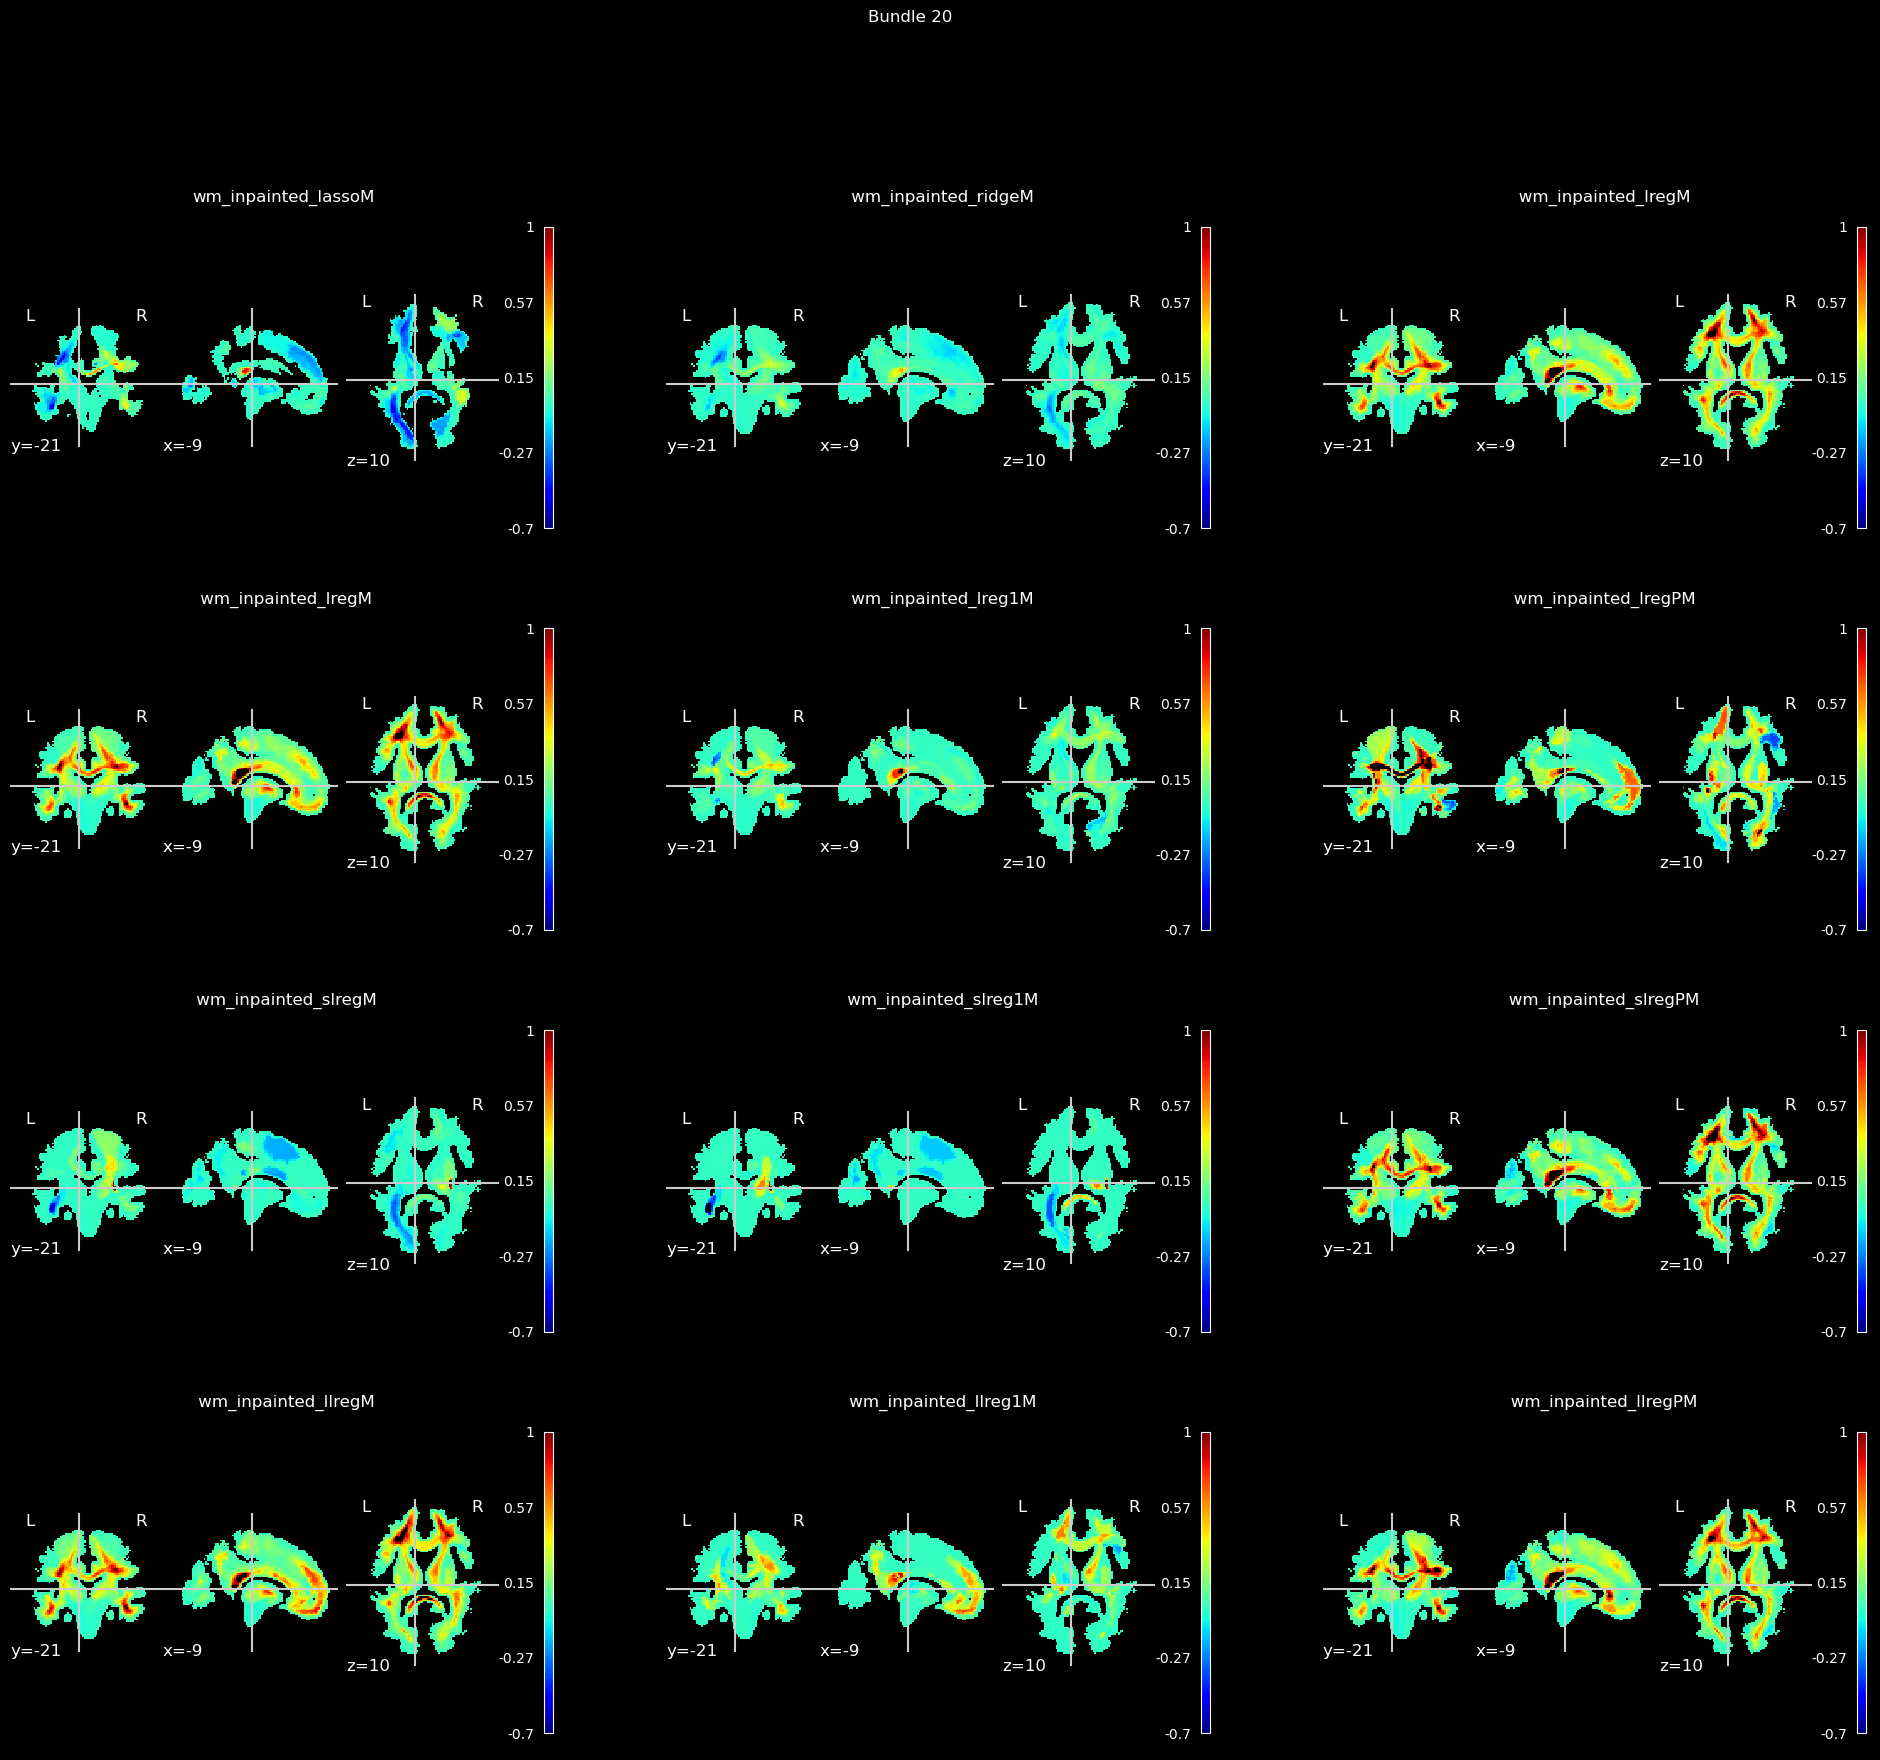

In [ ]:
inpaint_mods = [wm_inpainted_lasso, wm_inpainted_ridge,   wm_inpainted_lreg,
            wm_inpainted_lreg, wm_inpainted_lreg1,   wm_inpainted_lregP,
            wm_inpainted_slreg, wm_inpainted_slreg1,   wm_inpainted_slregP,
            wm_inpainted_llreg, wm_inpainted_llreg1,   wm_inpainted_llregP]

all_inpaints_names = 'wm_inpainted_lassoM, wm_inpainted_ridgeM,   wm_inpainted_lregM, wm_inpainted_lregM, wm_inpainted_lreg1M,   wm_inpainted_lregPM, wm_inpainted_slregM, wm_inpainted_slreg1M,   wm_inpainted_slregPM, wm_inpainted_llregM, wm_inpainted_llreg1M,   wm_inpainted_llregPM'.split(',')

affines = [rest_affine] * 12
coords_of_interest = [(-9,-21,10)] * 12
plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-0.7)

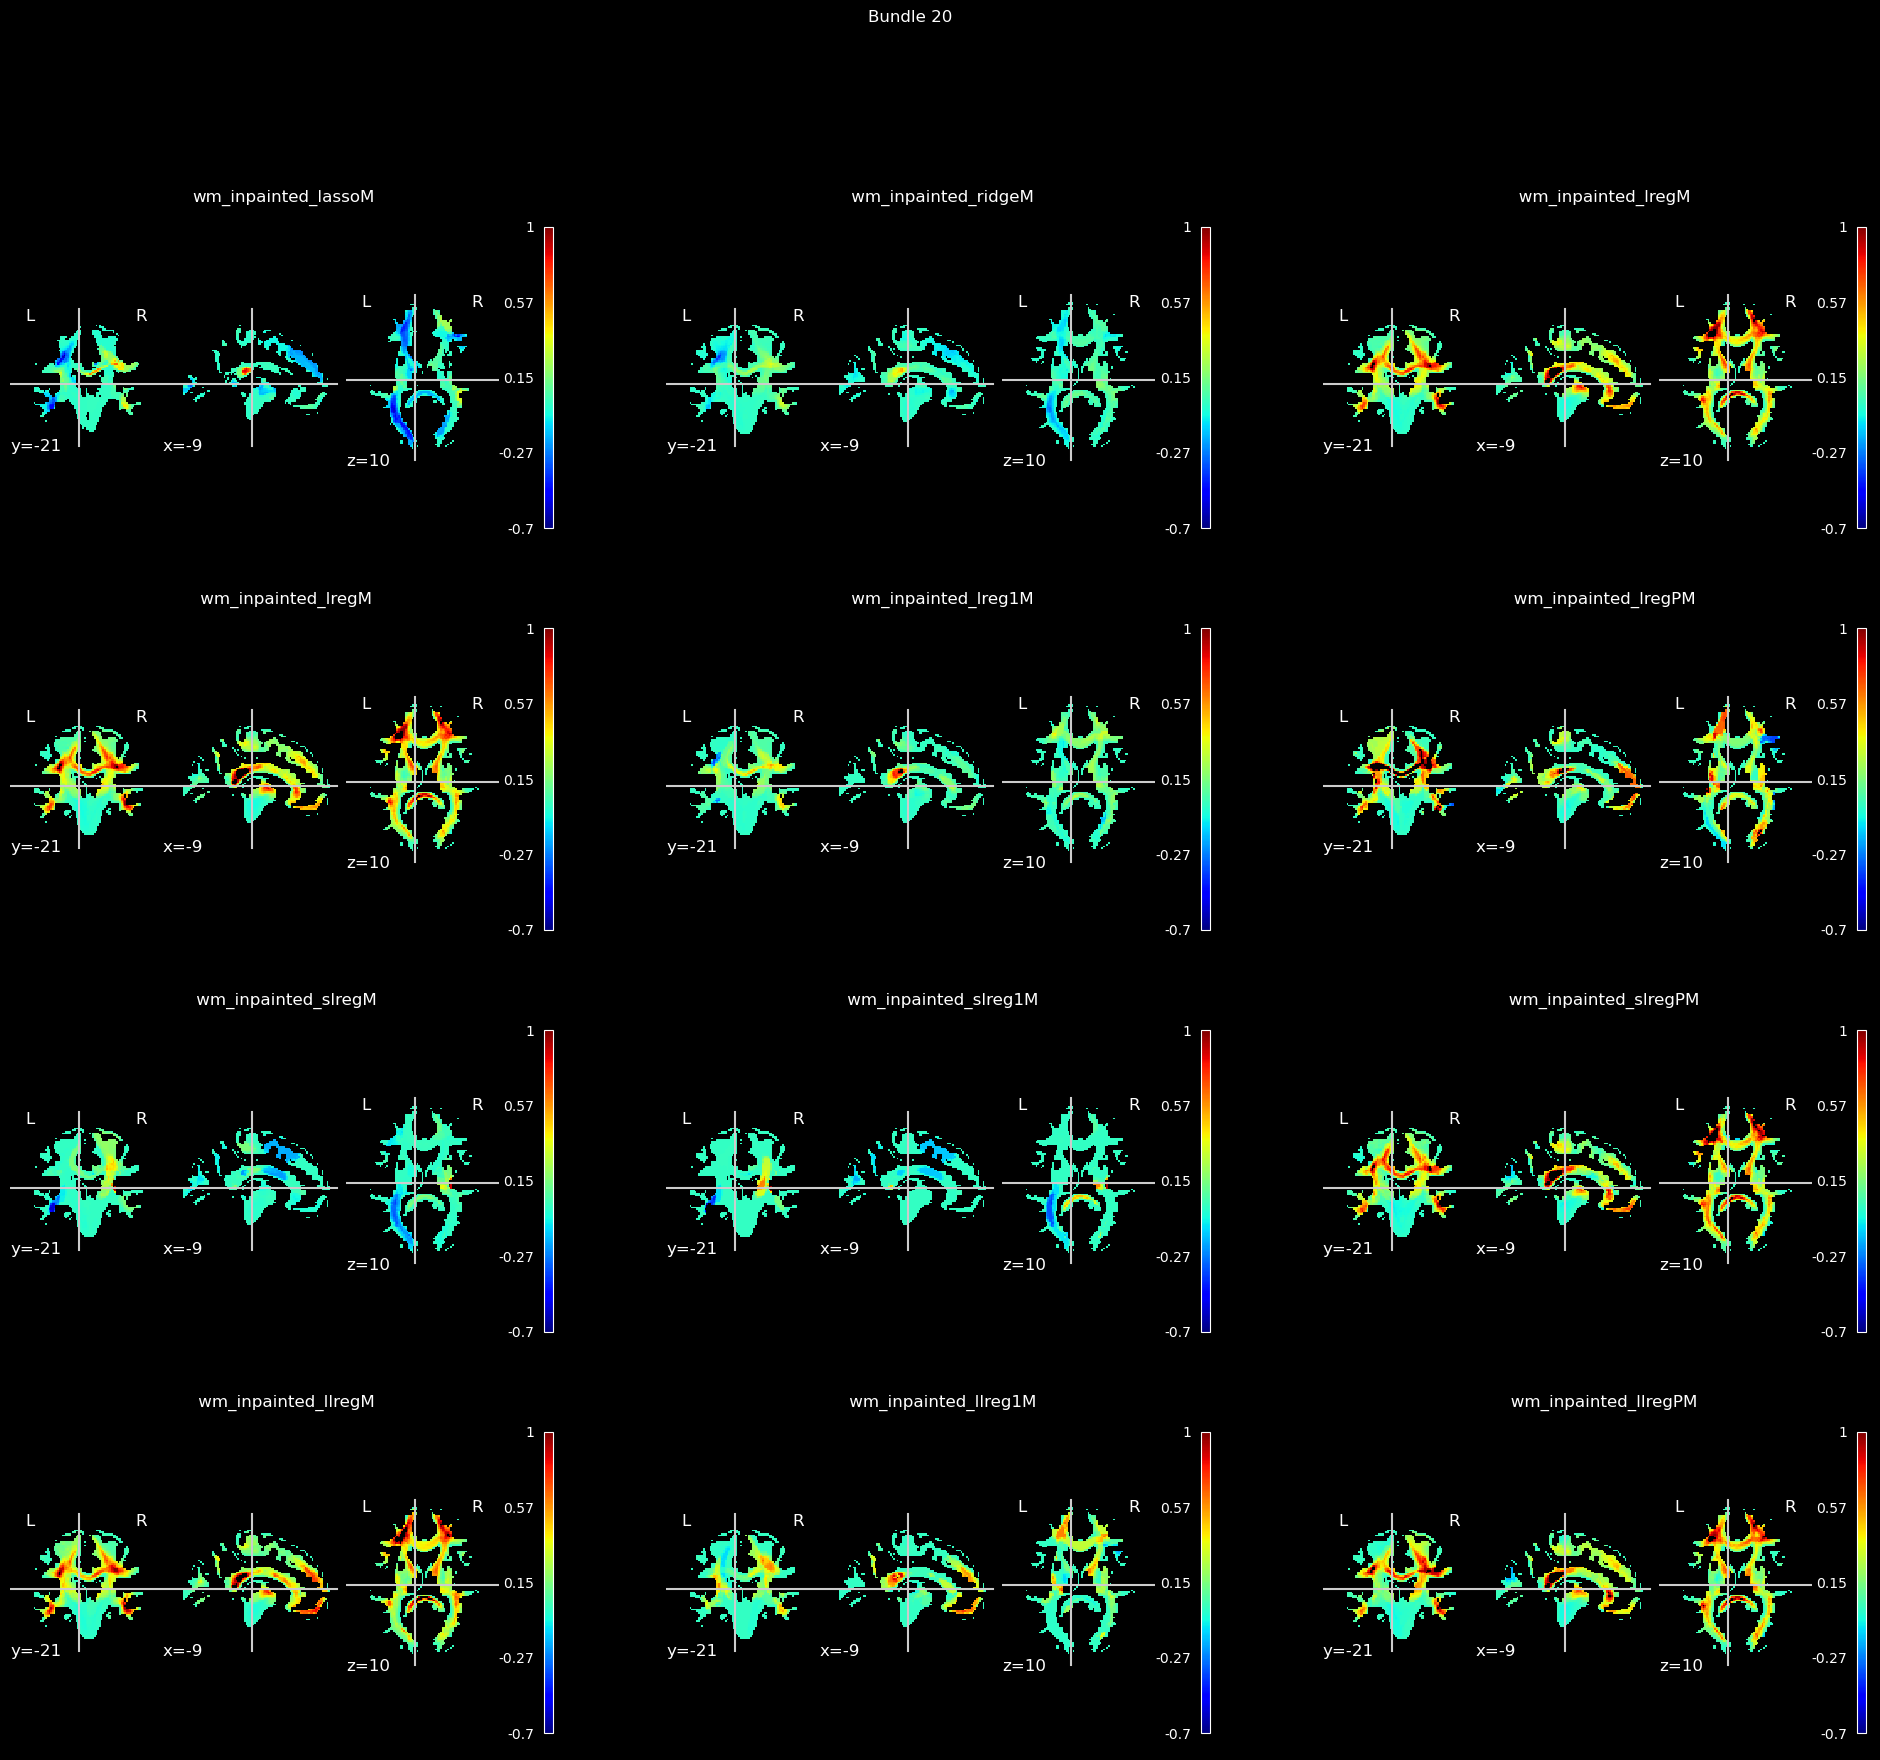

In [ ]:
inpaint_mods = [wm_inpainted_lassoM, wm_inpainted_ridgeM,   wm_inpainted_lregM,
            wm_inpainted_lregM, wm_inpainted_lreg1M,   wm_inpainted_lregPM,
            wm_inpainted_slregM, wm_inpainted_slreg1M,   wm_inpainted_slregPM,
            wm_inpainted_llregM, wm_inpainted_llreg1M,   wm_inpainted_llregPM]

all_inpaints_names = 'wm_inpainted_lassoM, wm_inpainted_ridgeM,   wm_inpainted_lregM, wm_inpainted_lregM, wm_inpainted_lreg1M,   wm_inpainted_lregPM, wm_inpainted_slregM, wm_inpainted_slreg1M,   wm_inpainted_slregPM, wm_inpainted_llregM, wm_inpainted_llreg1M,   wm_inpainted_llregPM'.split(',')

affines = [rest_affine] * 12
coords_of_interest = [(-9,-21,10)] * 12
plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-0.7)

#### Best 3 models showing for inpainted + gm connectivity added

In [ ]:
from scipy.ndimage import gaussian_filter

best_mods = [wm_inpainted_lreg, wm_inpainted_lregP,   wm_inpainted_llreg,
            wm_inpainted_lreg, wm_inpainted_lregP,   wm_inpainted_llreg,
            wm_inpainted_lreg, wm_inpainted_lregP,   wm_inpainted_llreg,
            wm_inpainted_lreg, wm_inpainted_lregP,   wm_inpainted_llreg]

best_mods_gmadd = []
for inpaint in best_mods:
    tmp = deepcopy(inpaint)
    tmp[tmp==-10] = 0
    tmp = tmp * wm_mask_subj
    tmp = tmp + seed_connect_gm
    tmp_mask = tmp != 0
    tmp = gaussian_filter(tmp, sigma=0.7)
    tmp = tmp * tmp_mask
    tmp[tmp==0] = -10
    best_mods_gmadd.append(tmp)

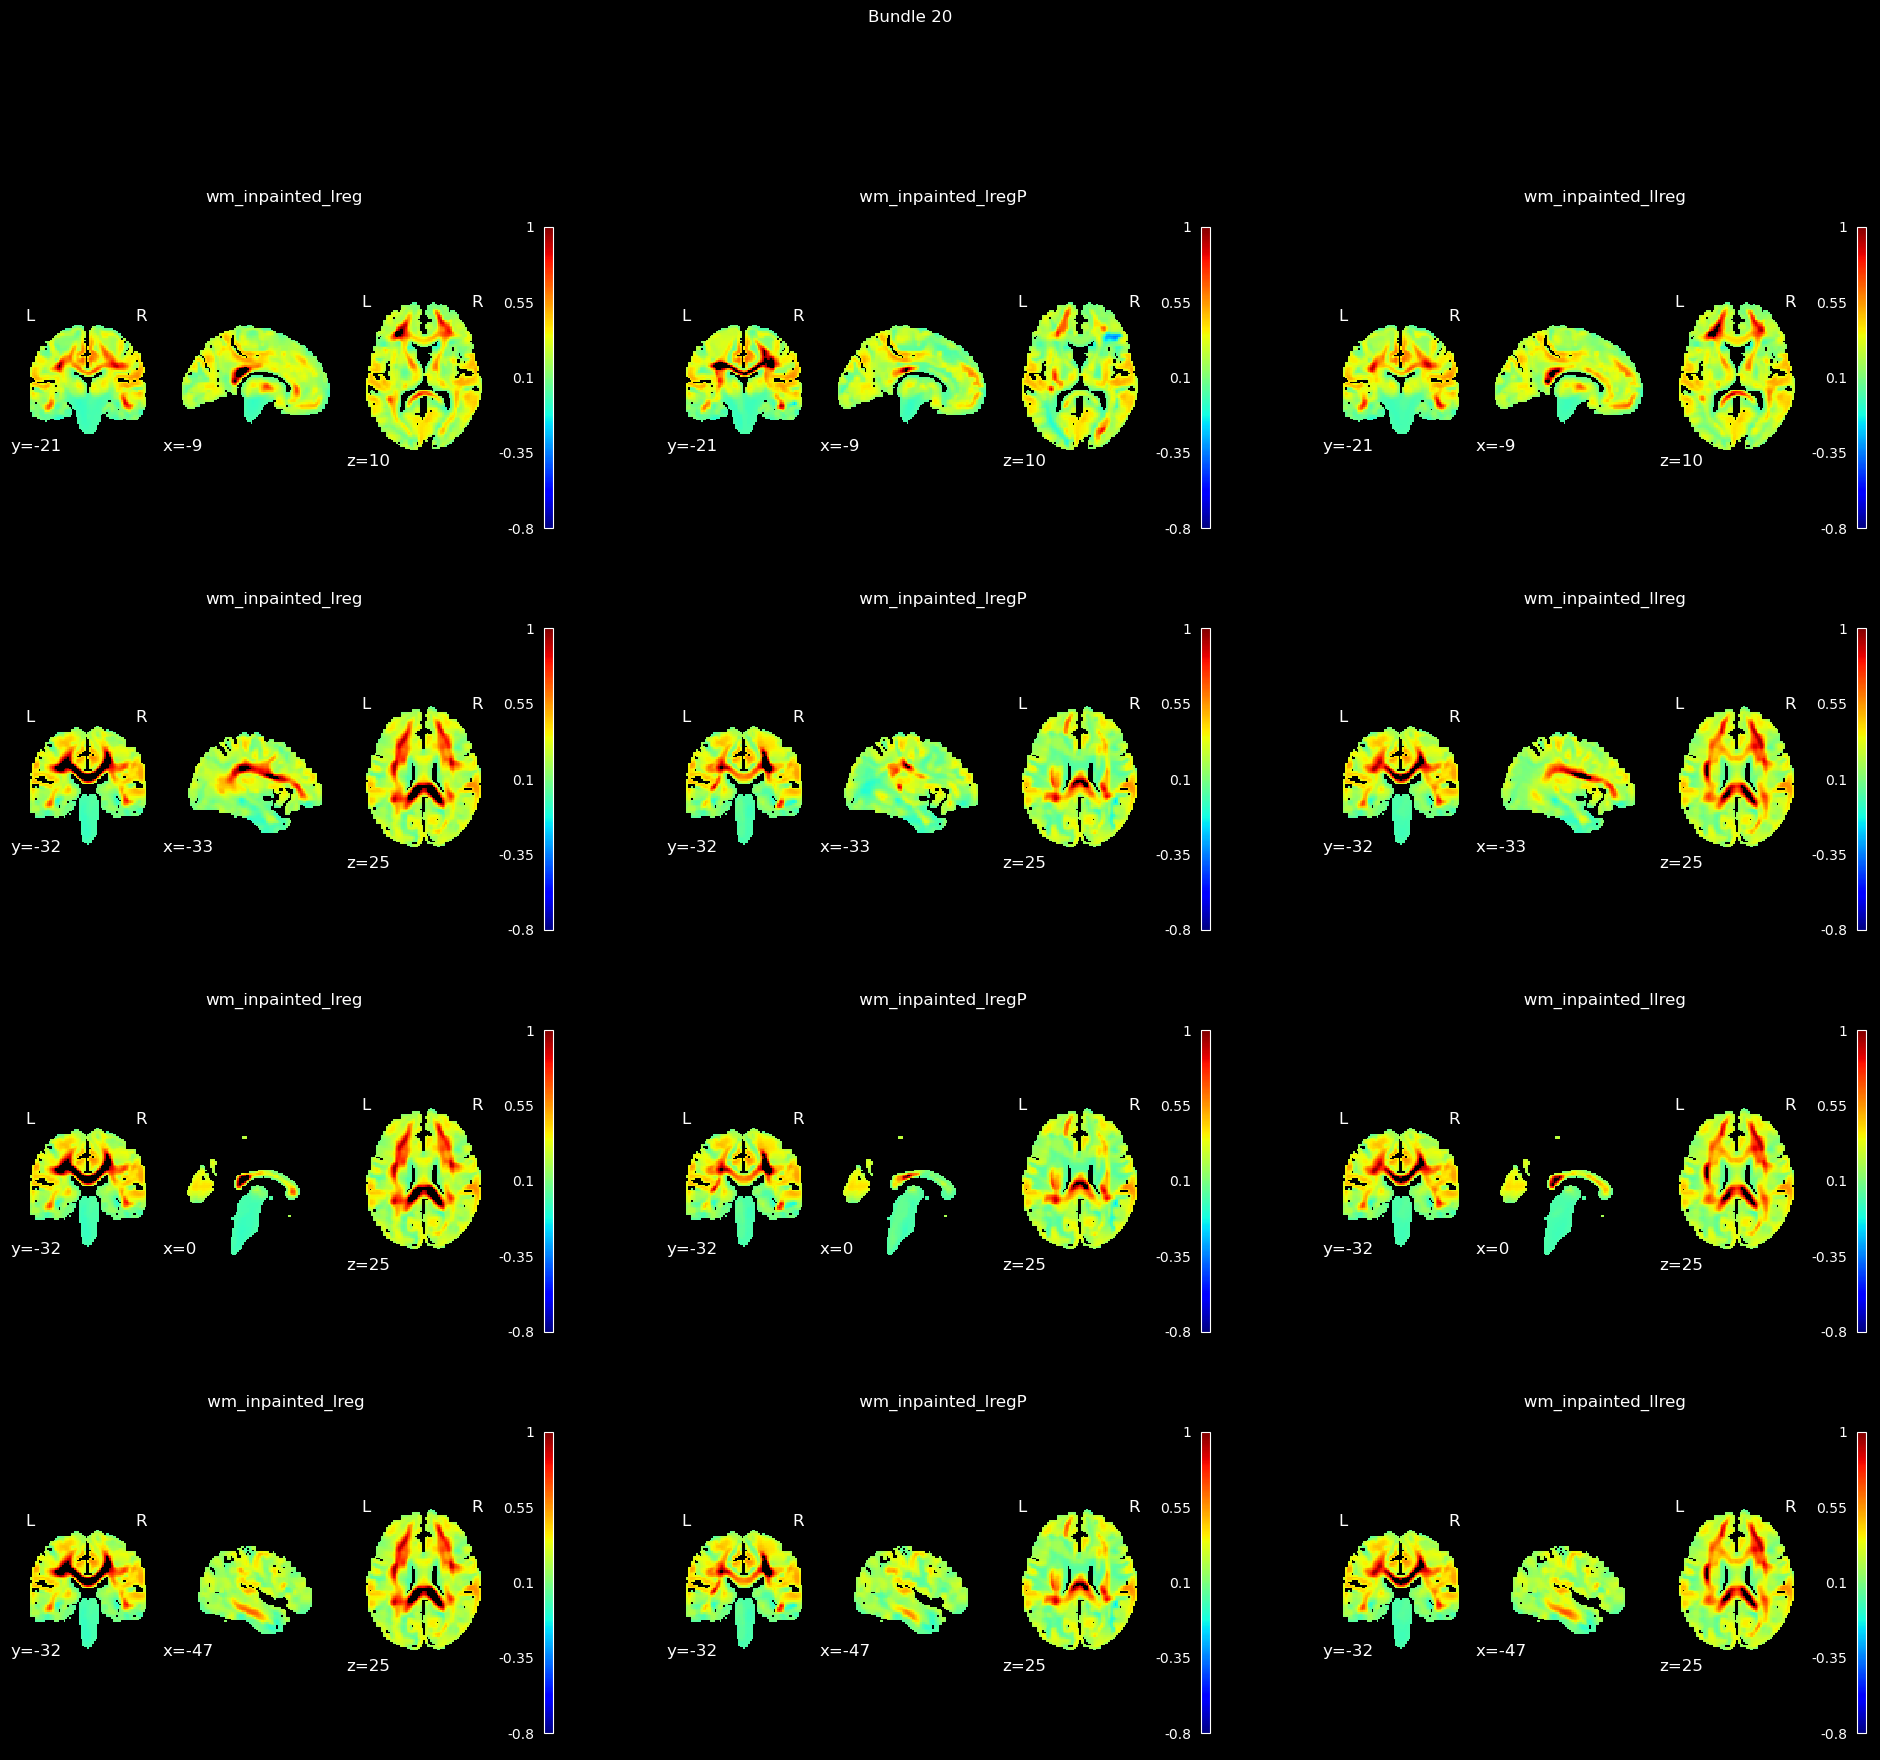

In [ ]:
# Best 3 model on regions of interest
all_inpaints_names = 'wm_inpainted_lreg, wm_inpainted_lregP,   wm_inpainted_llreg,wm_inpainted_lreg, wm_inpainted_lregP,   wm_inpainted_llreg,wm_inpainted_lreg, wm_inpainted_lregP,   wm_inpainted_llreg, wm_inpainted_lreg, wm_inpainted_lregP,   wm_inpainted_llreg'.split(',')
coords_of_interest = np.concatenate([[(-9,-21,10), (-33,-32,25), (0,-32,25), (-47,-32,25)]] * 3, axis=1).reshape(4,3,3).reshape(12,3)
plot_compare_inpainting(best_mods_gmadd, coords_of_interest, affines, all_inpaints_names, vmin=-0.8)

PCC only generated inpainting

In [ ]:
pcc_index_bundle = []
for k in range(len(bundles_labels)):
    a,b = bundles_labels[k]
    if (a in index_of_interest) or (b in index_of_interest):
        pcc_index_bundle.append(k)
pcc_index_bundle = np.asarray(pcc_index_bundle)

fmri_coords_pcc = [fmri_coords[pcc_index_bundle[k]] for k in range(len(pcc_index_bundle))]
bundles_labels_pcc = [bundles_labels[pcc_index_bundle[k]] for k in range(len(pcc_index_bundle))]

In [ ]:
inpainted_pcc_lreg, inpainted_pcc_lregM = interpolate_connectivity(fmri_coords_pcc, bundles_labels_pcc,
                                                cL2_reg[pcc_index_bundle], corr_mat, vdim)

inpainted_pcc_lreg1, inpainted_pcc_lreg1M = interpolate_connectivity(fmri_coords_pcc, bundles_labels_pcc,
                                                cL1_reg[pcc_index_bundle], corr_mat, vdim)

inpainted_pcc_lregP, inpainted_pcc_lregPM = interpolate_connectivity(fmri_coords_pcc, bundles_labels_pcc,
                                            cPL2_reg[pcc_index_bundle], corr_mat, vdim)

100%|██████████| 55/55 [00:00<00:00, 251.83it/s]


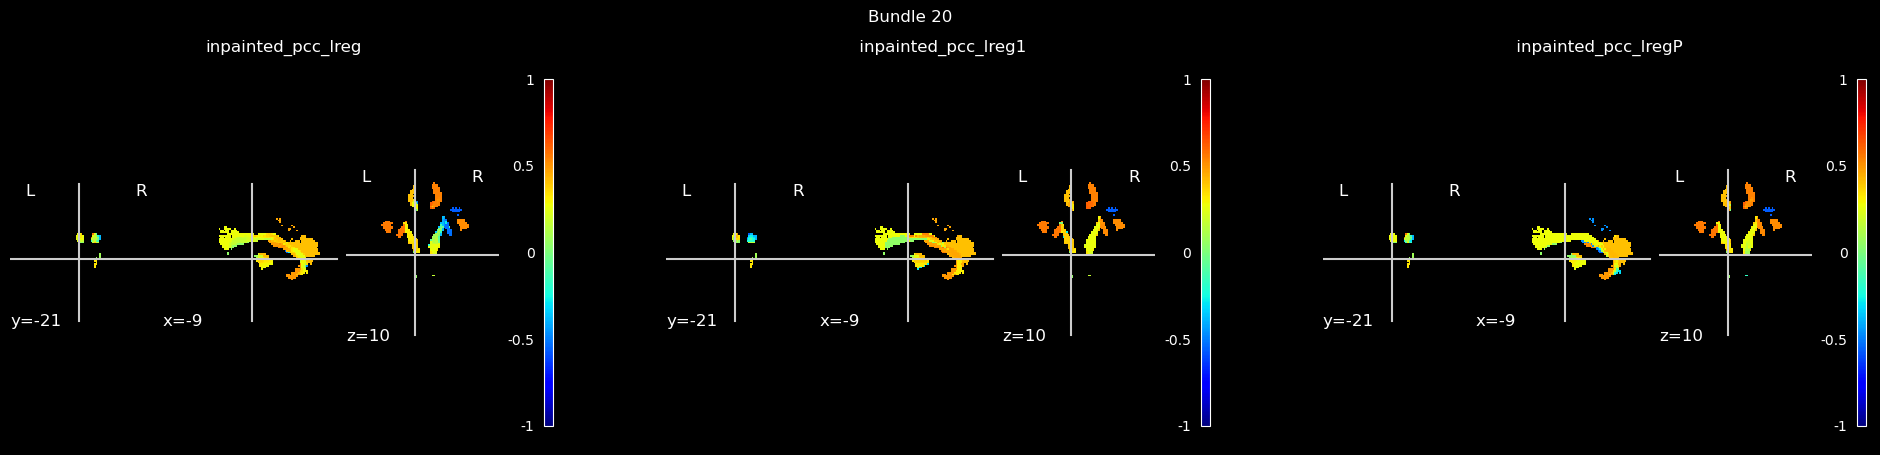

In [ ]:
coords_of_interest = [(-9,-21,10)] * 3
affines = [rest_affine] * 3
runs = [inpainted_pcc_lreg, inpainted_pcc_lreg1, inpainted_pcc_lregP]
all_inpaints_names = 'inpainted_pcc_lreg, inpainted_pcc_lreg1, inpainted_pcc_lregP'.split(',')

plot_compare_inpainting(runs, coords_of_interest, affines, all_inpaints_names)

In [ ]:
# NOTE: Close the opened h5 file
hf.close()

In [ ]:
# lreg_scores = np.zeros_like(scores)
# lreg_scores[:] = loss_func(y_pred, ytorch).detach().item()

# consistency_scores_lasso = np.array([consistency_regularizer(coefs_lasso[i], Cscale1) for i in range(len(coefs_lasso))])
# consistency_scores = np.array([consistency_regularizer(coefs[i], Cscale1) for i in range(len(coefs))])
# consistency_scores_lasso[consistency_scores_lasso == 0] = np.nan
# consistency_scores[consistency_scores == 0] = np.nan
# consistency_scores_lreg = np.zeros_like(scores)
# consistency_scores_lreg[:] = consistency_regularizer(mlp_weight, Cscale1)

# fig, ax = plt.subplots(1, 3, figsize=(25,5))

# clf = Lasso()
# clf.intercept_ = intercepts_lasso[4]
# clf.coef_ = coefs_lasso[4]
# pred_lasso = clf.predict(X.T)

# clf = Ridge()
# clf.intercept_ = intercepts[3]
# clf.coef_ = coefs[3]
# pred_ridge = clf.predict(X.T)

# ax[0].plot(ytorch.detach().numpy().flatten(), label='ground truth', linestyle='--', alpha=0.8, c='k')
# ax[0].plot(y_pred.detach().numpy().flatten(), label='predicted', alpha=0.5)
# ax[0].plot(pred_lasso, label='predicted lasso', alpha=0.5)
# ax[0].plot(pred_ridge, label='predicted ridge', alpha=0.5)
# ax[0].legend()

# ax[1].plot(scores_lasso, label='train mse loss Lasso')
# ax[1].plot(scores, label='train mse loss Ridge')
# ax[1].plot(lreg_scores, label='train mse loss Consistency regularizer')
# ax[1].set_yscale('log')

# ax[1].plot(consistency_scores_lasso, linestyle='--', label='consistency loss lasso')
# ax[1].plot(consistency_scores, linestyle='--', label='consistency loss Ridge')
# ax[1].plot(consistency_scores_lreg, linestyle='--', label='consistency loss Consistency regularizer')
# ax[1].legend()
# ax[1].set_xlabel('Regularizer weighting')

# # The different coefs chosen and regularizers choen
# ax[2].plot(zscore(coefs_lasso[4]), label='lasso coeff', alpha=0.5)
# ax[2].plot(zscore(coefs[3]), label='ridge coef', alpha=0.5)
# ax[2].plot(zscore(mlp_weight), label='mlp weights', alpha=0.5)
# ax[2].set_xlabel('valid bundles')
# ax[2].legend()

# plt.suptitle('PCC-Bundle{}'.format(thresh_subjapp))
# scores_lasso[np.argmax(np.abs(np.diff(scores_lasso)))-1]

Interpolating using fmri timecourse instead of connectivity

In [ ]:
# m_seedgm, std_seedgm = compute_stats(seed_connect_gm)
# normalized_inpainted_lasso = proc_inpainted(wm_inpainted_lasso, m_seedgm, std_seedgm, sparsifier=0.6)
# normalized_inpainted_ridge = proc_inpainted(wm_inpainted_ridge, m_seedgm, std_seedgm, sparsifier=0.6)
# normalized_inpainted_lreg = proc_inpainted(wm_inpainted_lreg, m_seedgm, std_seedgm, sparsifier=0.6)

# normalized_inpainted_lreg1 = proc_inpainted(wm_inpainted_lreg1, m_seedgm, std_seedgm, sparsifier=0.6)
# normalized_inpainted_lregP = proc_inpainted(wm_inpainted_lregP, m_seedgm, std_seedgm, sparsifier=0.6)
# normalized_inpainted_slreg = proc_inpainted(wm_inpainted_slreg, m_seedgm, std_seedgm, sparsifier=0.6)
# normalized_inpainted_slreg1 = proc_inpainted(wm_inpainted_slreg1, m_seedgm, std_seedgm, sparsifier=0.6)
# normalized_inpainted_slregP = proc_inpainted(wm_inpainted_slregP, m_seedgm, std_seedgm, sparsifier=0.6)
# normalized_inpainted_llreg = proc_inpainted(wm_inpainted_llreg, m_seedgm, std_seedgm, sparsifier=0.6)
# normalized_inpainted_llreg1 = proc_inpainted(wm_inpainted_llreg1, m_seedgm, std_seedgm, sparsifier=0.6)
# normalized_inpainted_llregP = proc_inpainted(wm_inpainted_llregP, m_seedgm, std_seedgm, sparsifier=0.6)

In [ ]:
# # INTERPOLATE fMRI TIMECOURSE
# # Iterate across all the bundles and populate each voxels by the timcourses
# wm_inpainted = np.zeros_like(ftimecourse)
# for k in tqdm(range(len(bundles_labels))):
#     i,j = bundles_labels[k]
#     volcoords_interest = fmri_coords[k]
#     avg_betweenbundle_course = (avg_tc[i-1] + avg_tc[j-1])/2

#     for coord in volcoords_interest:
#         x,y,z = coord
#         wm_inpainted[x,y,z,:] = wm_inpainted[x,y,z,:] + coefs2use[k] *  avg_betweenbundle_course

# seedfunc_vol_WM = np.zeros((ftimecourse.shape[:-1]))
# for x in tqdm(range(seedfunc_vol_WM.shape[0])):
#     for y in range(seedfunc_vol_WM.shape[1]):
#         for z in range(seedfunc_vol_WM.shape[2]):
#             seedfunc_vol_WM[x,y,z] = pearsonr(wm_inpainted[46,48,55], wm_inpainted[x,y,z])[0]

In [ ]:
# # compute the masks for different scales for each bundles (1 mask for 1 bundle)
# trans_affine = np.matmul(np.linalg.inv(rest_affine), bundle_affine)

# fmri_masks = []
# for k in tqdm(range(len(bundles_labels))):
#     i,j = bundles_labels[k]
#     streamline = get_bundles_betweenreg(hf, i,j)
#     # Transform voxel indexes of a volume to voxel index of another volume
#     volcoords_interest = volcoord2mnicoord(streamline[:,[0,1,2]], trans_affine).astype(int)

#     # fmri_coords.append(volcoords_interest)
#     tmp_mask = np.zeros_like(ftimecourse[:,:,:,0])
#     for coord in volcoords_interest:
#         x,y,z = coord
#         tmp_mask[x,y,z] = 1.0
#     fmri_masks.append(tmp_mask)

# # Save the space coords matching
# save('./resources/scale1_fmri2atlas_mask.pkl', fmri_masks)